In [1]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
print('Current working directory: ' + os.getcwd())
os.chdir('../downloads')
print('New working directory: ' + os.getcwd())

Current working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\notebooks
New working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\downloads


In [3]:
# db = []
# for f in os.listdir(os.getcwd()+ os.sep + '230821'):
#     file = open(os.getcwd() + os.sep + '230821' + os.sep + f)
#     data = json.load(file)
#     file.close()

In [4]:
date = '230821'

In [5]:
for f in os.listdir(os.getcwd()+ os.sep + date):
    file = open(os.getcwd() + os.sep + date + os.sep + f)
    data = json.load(file)
    file.close()
    break

In [6]:
data.keys()

dict_keys(['match_id', 'barracks_status_dire', 'barracks_status_radiant', 'chat', 'cluster', 'cosmetics', 'dire_score', 'dire_team_id', 'draft_timings', 'duration', 'engine', 'first_blood_time', 'game_mode', 'human_players', 'leagueid', 'lobby_type', 'match_seq_num', 'negative_votes', 'objectives', 'picks_bans', 'positive_votes', 'radiant_gold_adv', 'radiant_score', 'radiant_team_id', 'radiant_win', 'radiant_xp_adv', 'skill', 'start_time', 'teamfights', 'tower_status_dire', 'tower_status_radiant', 'version', 'replay_salt', 'series_id', 'series_type', 'players', 'patch', 'region', 'replay_url'])

In [7]:


def convert_seconds(time):
    ''''
    Converts time from integer to Hour:Minutes:Seconds format
    time: integer representation of time in seconds
    '''
    h = time//3600
    sec = time%60
    sec = ['0' + str(sec) if sec < 10 else sec][0]
    if h > 0 :
        time = time%3600
        minutes = time//60
        minutes = ['0' + str(minutes) if minutes < 10 else minutes][0]
        return(str(h)+ ':' + str(minutes)+ ':' + str(sec))
    else:
        return(str(time//60)+ ':' + str(sec))

In [8]:
convert_seconds(3900)

'1:05:00'

In [9]:
convert_seconds(data['duration']), convert_seconds(data['first_blood_time'])

('31:59', '2:28')

# Can consider following dimensions
## Pre Game
- patch 49 -> 7.30
- match_id
- game_mode, human_players, skill, region

## During Game
- picks_ban # A list of dictionaries containing a boolean relating to whether the choice is a pick or a ban, the hero ID, the team the picked or banned it, and the order.
- fb time

## End game
- radiant_win #True -> Radiant, False -> Dire
- Duration
- barracks_status_dire, barracks_status_radiant
- dire_score, Radiant_score #integer signifying the number of kills




In [10]:
db = []
for f in os.listdir(os.getcwd()+ os.sep + '230821'):
    file = open(os.getcwd() + os.sep + '230821' + os.sep + f)
    data = json.load(file)
    file.close()
    
    #ignoring errors by skipping
    if "error" in data.keys():
        continue
    # skip those with bots
    if data["human_players"] != 10:
        continue
    #skip those with no pick data
    if not data["picks_bans"]:
        continue
    
    #radiant = team 0
    win_team = 0
    if data["radiant_win"] == False:
        win_team = 1
    
    # get pick info
    picks = pd.DataFrame(data['picks_bans'])
    picks = picks[picks.is_pick] # drop bans
    picks = picks.sort_values('order')

    #adding last 2 picks to database
    db.append([data['match_id'],
              picks.iloc[-1].hero_id,
              picks.iloc[-1].team == win_team])
    
    db.append([data['match_id'],
              picks.iloc[-2].hero_id,
              picks.iloc[-2].team == win_team])
db = pd.DataFrame(db, columns = ['match_id','hero_id','win'])
    
# keep heroes >= 50
count = db.hero_id.value_counts()
keep = count[count > 50].index
db = db[db.hero_id.isin(keep)]

#getting winrate
winrate = db.groupby('hero_id')['win'].mean()
winrate = winrate.sort_values()

# changing hero id to name

heroes = pd.read_csv('./hero_data/hero_stats_23August2021.csv')[['name','hero_id']] #only want the name and hero_id column
lookup = {k:v[14:] for k,v in zip(heroes.hero_id, heroes.name)}

def convert2name(id):
    return[lookup[i] for i in id]
    
    

In [11]:
heroes_data = pd.read_csv('./hero_data/hero_stats_23August2021.csv')
heroes_data.columns

Index(['Unnamed: 0', 'id', 'name', 'localized_name', 'primary_attr',
       'attack_type', 'roles', 'img', 'icon', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_mr', 'base_attack_min', 'base_attack_max', 'base_str', 'base_agi',
       'base_int', 'str_gain', 'agi_gain', 'int_gain', 'attack_range',
       'projectile_speed', 'attack_rate', 'move_speed', 'turn_rate',
       'cm_enabled', 'legs', 'hero_id', 'turbo_picks', 'turbo_wins', 'pro_win',
       'pro_pick', 'pro_ban', '1_pick', '1_win', '2_pick', '2_win', '3_pick',
       '3_win', '4_pick', '4_win', '5_pick', '5_win', '6_pick', '6_win',
       '7_pick', '7_win', '8_pick', '8_win', 'null_pick', 'null_win'],
      dtype='object')

In [12]:
heroes_df = heroes_data[['hero_id', 'localized_name',
                        'base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain']]

In [13]:
hero_id = 101

In [14]:
heroes_df[heroes_df['hero_id'] == hero_id]['localized_name'].values

array(['Skywrath Mage'], dtype=object)

In [15]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name].copy() - min_value) / (max_value - min_value)
    return result

In [16]:
test = heroes_df[['base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain']]

In [17]:
heroes_df[['base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain']] = normalize(test)

C:\Users\Boonchong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [18]:
heroes_df = heroes_df.fillna(0)
heroes_df

,hero_id,localized_name,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
0,1,Anti-Mage,0.0,0.000000,0.0,0.0,0.375,0.583333,0.705882,0.000000,0.032258,0.636364,0.190476
1,2,Axe,0.0,0.833333,0.0,0.0,0.250,0.750000,0.588235,0.333333,0.612903,0.500000,0.142857
2,3,Bane,0.0,0.000000,0.0,0.0,0.500,0.500000,0.647059,0.555556,0.354839,0.590909,0.380952
3,4,Bloodseeker,0.0,0.000000,0.0,0.0,0.625,0.666667,0.647059,0.277778,0.387097,0.772727,0.238095
4,5,Crystal Maiden,0.0,0.000000,0.0,1.0,0.250,0.166667,0.470588,0.222222,0.225806,0.363636,0.547619
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,123,Hoodwink,0.0,0.000000,0.0,0.0,0.375,0.083333,0.705882,0.500000,0.161290,0.818182,0.452381
117,126,Void Spirit,0.0,0.000000,0.0,0.6,0.250,0.500000,0.558824,0.666667,0.354839,0.500000,0.500000
118,128,Snapfire,0.0,0.000000,0.0,0.0,0.500,0.333333,0.470588,0.500000,0.645161,0.431818,0.285714
119,129,Mars,0.0,0.000000,0.0,0.5,0.250,0.583333,0.588235,0.500000,0.612903,0.386364,0.285714


In [23]:
heroes_df.loc[hero_id]['localized_name']

'Elder Titan'

In [29]:
fig = go.Figure()
fig.add_trace(
    go.Scatterpolar(
        r=list(heroes_df.loc[hero_id][['base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain']]),
        theta=['base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain'],
        mode='markers+lines',
        text=list(heroes_df.loc[hero_id]['localized_name']),
        textposition="top center",
        textfont_size=15,
        fill="toself",
        fillcolor="#008FD3",
        line=dict(color="#F0AB00"),
        marker=dict(color="#AB7A00",size=5),
        opacity=0.5,
        name=heroes_df.loc[hero_id]['localized_name']
    )
)
fig.update_traces(hovertemplate='%{theta}' + '<br>Value:%{r:2f}</br>', selector=dict(type='scatterpolar'))
fig.update_layout(title=dict(text=heroes_df.loc[hero_id]['localized_name'],x=0.5,y=0.95))
fig

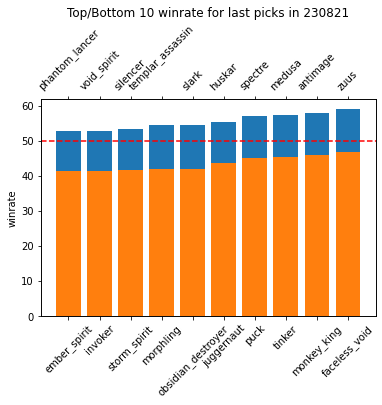

In [20]:
N = 10
tail10 = winrate.iloc[:N]
head10 = winrate.iloc[-N:]

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

ax1.bar(range(N), 100 * head10.values)
ax1.bar(range(N), 100 * tail10.values)

ax1.set_xticks(range(N))
ax1.set_xticklabels(convert2name(tail10.index))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(range(N))
ax2.set_xticklabels(convert2name(head10.index))
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.set_ylabel('winrate')

ax1.set_title('Top/Bottom 10 winrate for last picks in 230821')
ax1.axhline(y=50, linestyle='--', color='red')
plt.show()

In [21]:
tail10

hero_id
106    0.413793
74     0.414286
17     0.417582
10     0.418182
76     0.418182
8      0.435484
13     0.450980
34     0.454545
114    0.458333
41     0.466667
Name: win, dtype: float64

In [22]:
head10

hero_id
12     0.526316
126    0.528302
75     0.532258
46     0.543210
93     0.544304
59     0.551724
67     0.571429
94     0.573529
1      0.578947
22     0.590164
Name: win, dtype: float64